<a href="https://colab.research.google.com/github/osryde/trophic_graph_analysis/blob/main/robustness_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analisi di Reti Trofiche
---

Il presente progetto si propone di investigare la vulnerabilità strutturale e funzionale delle reti trofiche attraverso un framework metodologico che integra la Network Theory e il Machine Learning non supervisionato. Prendendo le mosse dai criteri energetici proposti da _Bellingeri et al. (2025)_, lo studio analizza come la sensibilità dei consumatori alla perdita di risorse condizioni la propagazione delle estinzioni secondarie e la stabilità globale del sistema. I seguenti punti spiegano come si è articolato il progetto:
- La prima parte riguarda l'analisi di una **rete trofica** (`FW_008`). L'analisi ha permesso di identificare quali sono le specie il cui impatto sull'equilibrio della rete è maggiore. A tale scopo sono stati impiegati algoritmi di **community detection** per identificare quali sono i gruppi all'interno della rete strettamente legati, verificando l'ipotesi secondo la quale un'estinzione primaria andrà ad intaccare principalmente la propria comunità di appartenenza.
- La seconda parte del progetto si è basata sull'applicare un'**Analisi esplorativa dei dati** sulla totalità del dataset delle reti trofiche, cercando la formazione naturale di gruppi in base a **feature** che rispecchiano complessità e fragilità della rete.

Nel complesso, la prima sezione analizza l'effetto locale delle estinzioni all'interno delle singole reti, mentre la seconda sezione amplia la prospettiva confrontando diverse reti e mostrando come proprietà strutturali globali siano associate a differenti livelli di fragilità.

**NB**: Come si legge: la riga dice chi viene mangiato, la colonna chi lo mangia

In [ ]:
!pip uninstall networkx -y
!pip uninstall python-louvain -y
!pip uninstall community -y
!pip install python-louvain
!pip install networkx

!pip install cdlib

In [35]:
# Inseriamo le librerie necessarie
import glob
import umap
import random
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
import hdbscan
import community as community_louvain
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

## 1. Analisi di una rete marina
La rete presa in esame per l'analisi della sua fragilità è `FW_008`. Questa rete è stata scelta per il suo alto numero di specie e la sua connettività.

In [36]:
# Andiamo ad estrarre i dati
path = "FW_008.csv"
df = pd.read_csv(path, index_col=0)

df

,Abudefduf saxatilis,Abudefduf taurus,Acanthostracion polygonius,Acanthostracion quadricornis,Acanthurus bahianus,Acanthurus chirurgus,Acanthurus coeruleus,Aetobatus narinari,Allanetta harringtonensis,Alphestes afer,...,Tarpon atlanticus,Thalassoma bifasciatum,Trachinotus falcatus,Trachinotus goodei,Tunicates,Tylosurus acus,Tylosurus crocodilus,Xyrichtys novacula,Xyrichtys splendens,Zooplankton
Abudefduf saxatilis,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001,0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.0,0.0,0.0
Abudefduf taurus,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001,0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.0,0.0,0.0
Acanthostracion polygonius,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.0,0.0,0.0
Acanthostracion quadricornis,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.0,0.0,0.0
Acanthurus bahianus,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001,0,0.012,...,0.0,0.0,0.0,0.0,0.0,0.00,0.182,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Tylosurus acus,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.24,0.000,0.0,0.0,0.0
Tylosurus crocodilus,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.24,0.000,0.0,0.0,0.0
Xyrichtys novacula,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001,0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.0,0.0,0.0
Xyrichtys splendens,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001,0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.0,0.0,0.0


In [37]:
# Cerchiamo eventuali valori NaN nei dati
print("Numero di NaN:" , df.isna().sum().sum())
print("Dimensioni della tabella:", df.shape)

Numero di NaN: 0
Dimensioni della tabella: (248, 244)


La forma rettangolare della tabella indica la presenza di **autotrofi**, cioè specie che non si alimentano di altre specie all'interno del dataset. Per risolvere il problema, trasformiamo la matrice in una matrice quadrata, interpretando la loro assenza con un valore energetico nullo (**zero**) associato all'arco.

In [38]:
# Uniamo (usiamo l'operatore unione) tutti i nomi presenti sia negli indici che nelle colonne
all_species = sorted(list(set(df.index) | set(df.columns)))

# Re-indicizziamo il dataframe aggiungendo le righe/colonne mancanti riempite di 0
df_square = df.reindex(index=all_species, columns=all_species, fill_value=0)

print("Nuova forma della matrice:", df_square.shape)

Nuova forma della matrice: (249, 249)


Andiamo a creare il Grafo sul quale applicare gli algoritmi di **Community Detection**

In [39]:
# Convertiamo la matrice in un grafo diretto (Preda -> Predatore, flusso di energia)
G = nx.from_pandas_adjacency(df_square, create_using=nx.DiGraph)

print(f"Rete caricata: {len(G.nodes)} specie e {len(G.edges)} interazioni.")

Rete caricata: 249 specie e 3313 interazioni.


Analizziamo il grafo per vedere le specie **Autotrofiche** e **Apex predators**.

In [40]:
basal_species = [n for n in G.nodes if G.in_degree(n) == 0]
print(f"Specie basali (Autotrofi): {basal_species}")
apex_species = [n for n in G.nodes if G.out_degree(n) == 0]
print(f"Apex predators: {apex_species}")

Specie basali (Autotrofi): ['Benthic autotrophs', 'Detritus', 'Phytoplankton', 'Symbiotic algae', 'Synodus synodus']
Apex predators: ['Galeocerdo cuvieri']


Archi originali: 3313
Archi dopo filtro (top 25%): 839


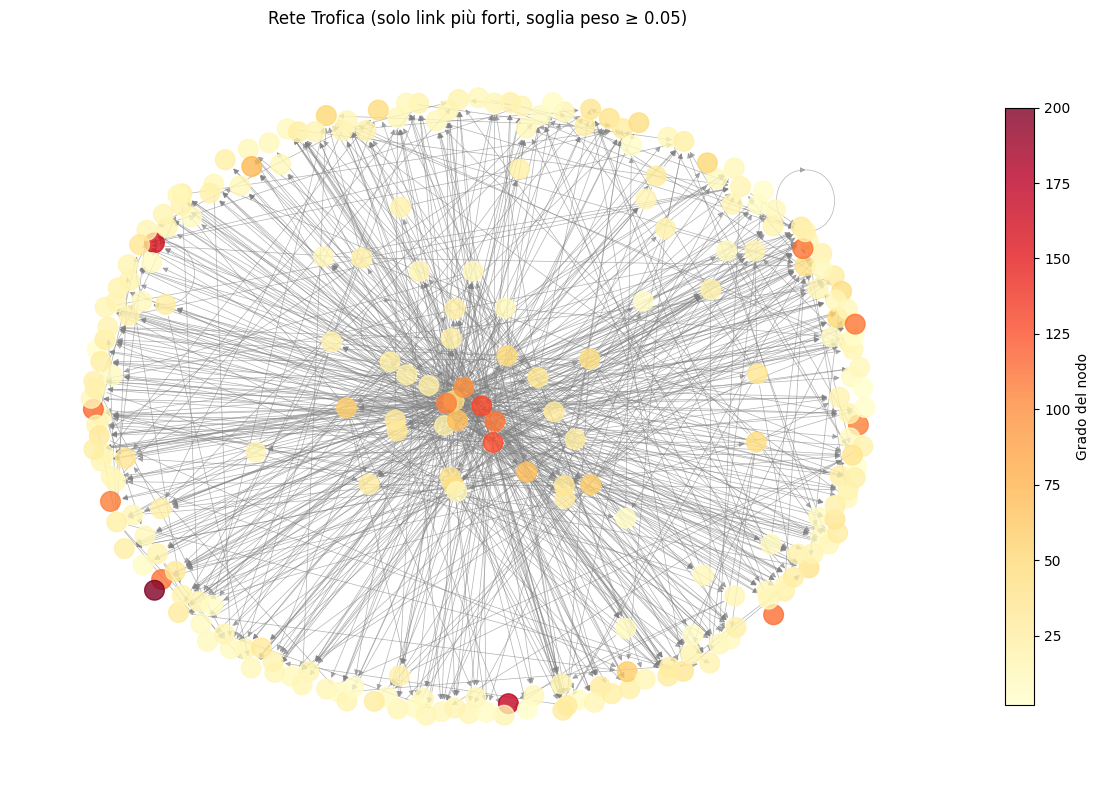

In [41]:
# Vediamo graficamente il grafo creato
# Filtriamo gli archi deboli per migliorare la leggibilità

# Calcoliamo la soglia: teniamo solo archi con peso > 75° percentile
weights = [d['weight'] for u, v, d in G.edges(data=True)]
threshold_weight = np.percentile(weights, 75)

# Creiamo un sottografo con solo gli archi "forti"
G_filtered = nx.DiGraph()
G_filtered.add_nodes_from(G.nodes())
for u, v, d in G.edges(data=True):
    if d['weight'] >= threshold_weight:
        G_filtered.add_edge(u, v, **d)

print(f"Archi originali: {G.number_of_edges()}")
print(f"Archi dopo filtro (top 25%): {G_filtered.number_of_edges()}")

fig, ax = plt.subplots(figsize=(12, 8))
pos = nx.spring_layout(G_filtered, k=0.8, seed=42, iterations=100)

# Coloriamo i nodi per grado (nel grafo originale)
node_degrees = [G.degree(n) for n in G_filtered.nodes()]

nodes = nx.draw_networkx_nodes(G_filtered, pos, ax=ax,
        node_size=200,
        node_color=node_degrees,
        cmap=plt.cm.YlOrRd,
        alpha=0.8)

nx.draw_networkx_edges(G_filtered, pos, ax=ax,
        edge_color='gray',
        arrowsize=8,
        width=0.5,
        alpha=0.6)

ax.set_title(f"Rete Trofica (solo link più forti, soglia peso ≥ {threshold_weight:.2f})")
plt.colorbar(nodes, ax=ax, label='Grado del nodo', shrink=0.8)
ax.axis('off')
plt.tight_layout()
plt.show()

### 1.2 Implementazione estinzione

In questa sezione andremo a simulare la fragilità della rete causata dalle **estinzioni primarie**.

Per misurare l'estinzione usiamo il valore **th**, cioè l'energia in entrata (la somma dell'energia entrante) in un nodo. Questa soglia rappresenta la quantità percentuale di energia sotto la quale una specie va in estinzione.

Dunque, **ad esempio**, con $th = 0.1$ una specie andrà in estinzione se l'energia entrante totale cade sotto il $10\%$

Formalmente
$$
Energia Rimanente≤th×Energia Iniziale
$$

In [42]:
def simulate_energetic_extinction(graph, primary_node, th):
    temp_graph = graph.copy()

    # Usiamo la forza pesata iniziale
    initial_energy = dict(graph.in_degree(weight='weight'))

    temp_graph.remove_node(primary_node)
    extinct_nodes = {primary_node}

    new_extinctions = True
    while new_extinctions:
        new_extinctions = False
        to_remove = []
        for n in temp_graph.nodes():
            if initial_energy[n] > 0:
                # Calcoliamo l'energia rimanente basandoci sui pesi dei link rimasti
                current_energy = temp_graph.in_degree(n, weight='weight')
                if current_energy <= th * initial_energy[n]:
                    to_remove.append(n)
                    new_extinctions = True
        for n in to_remove:
            if n not in extinct_nodes:
                extinct_nodes.add(n)
                temp_graph.remove_node(n)
    return len(extinct_nodes) - 1

**NB**: Nella rimozione delle specie non andremo a considerare gli **apex consumers**, cioè quei nodi che non innescano estinzioni secondarie in quanto non vengono mangiati da nessuno (Quindi con $Grado > 0$).

In [43]:
# Eseguiamo un test con th per ogni nodo, identificando quale causa il maggior numero di estinzioni
threshold = 0.5
energetic_results = {n: simulate_energetic_extinction(G, n, threshold) for n in G.nodes if G.out_degree(n) > 0}

# Ordiniamo e mostriamo i nuovi risultati
sorted_energetic = sorted(energetic_results.items(), key=lambda x: x[1], reverse=True)
print(f"\nTop 5 Specie Keystone con th={threshold}:")
for species, count in sorted_energetic[:5]:
    print(f"- {species}: {count} estinzioni secondarie")


Top 5 Specie Keystone con th=0.5:
- Detritus: 188 estinzioni secondarie
- Benthic autotrophs: 49 estinzioni secondarie
- Microfauna: 41 estinzioni secondarie
- Shrimps: 14 estinzioni secondarie
- Crabs: 9 estinzioni secondarie


### 1.2.1 Robustezza della rete

Andiamo ora a definire la formula $R_\alpha$, che indica la robustezza strutturale e rappresenta il numero necessario di **estinzioni primarie** che causano un numero $\alpha$ di estinzioni totali.

$$
R_\alpha = \frac{E}{S}
$$

dove:
- $E$ è il numero di estinzioni primarie necessarie
- $S$ è il numero iniziale di Specie


Per simulare le **estinzioni primarie** utilizziamo due approcci:
- **Rimozione randomica**: Gli elementi vengono rimossi randomicamente fino a raggiungere la soglie di estinzioni
- **Rimozione ordinata**: Vengono rimossi i nodi in ordine di link (in + out)

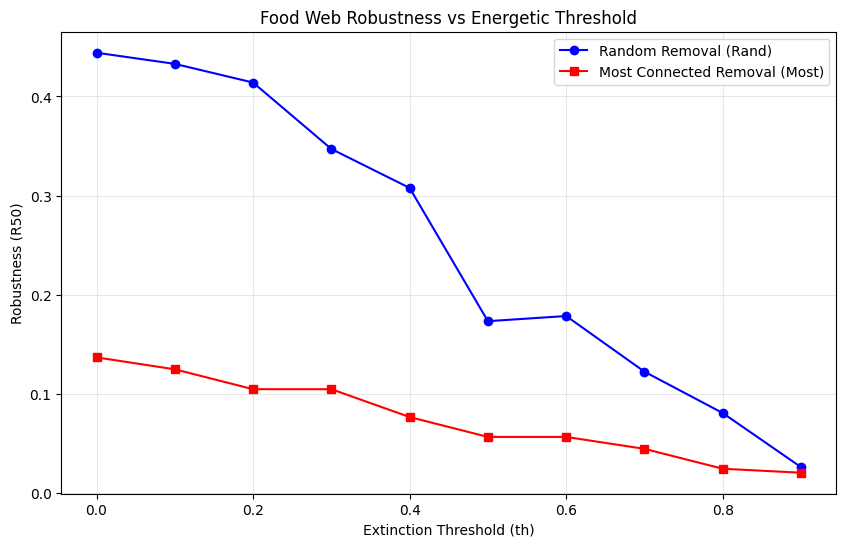

In [44]:
def calculate_R50(graph, th, strategy='random', simulations=10):
    """
    Calcola l'indice R50 per una data soglia th e una strategia di rimozione.
    """
    S = len(graph.nodes())
    target = 0.5 * S  # Obiettivo: 50% di estinzioni totali

    r50_values = []

    for _ in range(simulations):
        temp_graph = graph.copy()
        initial_in_degree = {n: graph.in_degree(n) for n in graph.nodes()}

        # Scegliamo l'ordine di rimozione
        nodes_to_remove = list(graph.nodes())
        if strategy == 'most':
            # Ordine decrescente per numero di link (in + out)
            nodes_to_remove = sorted(nodes_to_remove, key=lambda x: graph.degree(x), reverse=True)
        else:
            random.shuffle(nodes_to_remove)

        extinct_total = set()
        primary_count = 0

        for p_node in nodes_to_remove:
            if p_node in extinct_total: continue

            # 1. Estinzione Primaria
            primary_count += 1
            extinct_total.add(p_node)
            if p_node in temp_graph:
                temp_graph.remove_node(p_node)

            # 2. Cascata di Estinzioni Secondarie (Logica Energetica)
            new_extinctions = True
            while new_extinctions:
                new_extinctions = False
                to_remove_secondary = []
                for node in temp_graph.nodes():
                    if initial_in_degree[node] > 0:
                        current_energy = temp_graph.in_degree(node)
                        # Se l'energia scende sotto la soglia th
                        if current_energy <= th * initial_in_degree[node]:
                            to_remove_secondary.append(node)
                            new_extinctions = True

                for node in to_remove_secondary:
                    extinct_total.add(node)
                    temp_graph.remove_node(node)

            # Controlliamo se abbiamo raggiunto il 50%
            if len(extinct_total) >= target:
                break

        r50_values.append(primary_count / S)

    return sum(r50_values) / simulations

# Calcolo delle curve per i grafici
thresholds = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
r50_rand = [calculate_R50(G, t, strategy='random') for t in thresholds]
r50_most = [calculate_R50(G, t, strategy='most') for t in thresholds]

# Visualizzazione (Simile alla Figura 1A del paper)
plt.figure(figsize=(10, 6))
plt.plot(thresholds, r50_rand, 'o-', label='Random Removal (Rand)', color='blue')
plt.plot(thresholds, r50_most, 's-', label='Most Connected Removal (Most)', color='red')
plt.xlabel('Extinction Threshold (th)')
plt.ylabel('Robustness (R50)')
plt.title('Food Web Robustness vs Energetic Threshold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Il grafico mostra il numero di estinzioni primarie necessarie per raggiungere il 50% delle estinzioni all'aumentare di **th**, cioè all'aumentare della fragilità della rete. Questo viene visualizzato usando due approcci differenti.

# 1.3 Community detection
Proviamo ora ad applicare community detection per trovare le specie molto legate tra di loro. Questo significa che un'estinzione primaria influenzerà principalmente la comunità di appartenenza.

In [45]:
# Community Detection con Louvain
# Usiamo il grafo non orientato per la community detection
G_undirected = G.to_undirected()

# Applichiamo l'algoritmo di Louvain
partition = community_louvain.best_partition(G_undirected, weight='weight', random_state=42)

# Calcoliamo la modularità (misura della qualità delle comunità)
modularity = community_louvain.modularity(partition, G_undirected, weight='weight')
print(f"Modularità della rete: {modularity:.3f}")
print(f"Numero di comunità trovate: {len(set(partition.values()))}")

Modularità della rete: 0.480
Numero di comunità trovate: 7


In [46]:
node_list = list(G.nodes())

df_communities = pd.DataFrame({
    'species': node_list,
    'community': [partition[n] for n in node_list],
    'in_degree': [G.in_degree(n) for n in node_list],
    'out_degree': [G.out_degree(n) for n in node_list],
    'impact': [energetic_results.get(n, 0) for n in node_list]
})

# Statistiche per comunità
print("\nStatistiche per comunità:")
for comm_id in sorted(df_communities['community'].unique()):
    comm_species = df_communities[df_communities['community'] == comm_id]
    avg_impact = comm_species['impact'].mean()
    max_impact_species = comm_species.loc[comm_species['impact'].idxmax(), 'species']
    print(f"  Comunità {comm_id}: {len(comm_species)} specie, impatto medio: {avg_impact:.1f}, keystone: {max_impact_species}")


Statistiche per comunità:
  Comunità 0: 22 specie, impatto medio: 0.7, keystone: Phytoplankton
  Comunità 1: 58 specie, impatto medio: 4.2, keystone: Detritus
  Comunità 2: 66 specie, impatto medio: 0.3, keystone: Crabs
  Comunità 3: 50 specie, impatto medio: 0.9, keystone: Microfauna
  Comunità 4: 4 specie, impatto medio: 0.8, keystone: Haemulon aurolineatum
  Comunità 5: 32 specie, impatto medio: 0.5, keystone: Shrimps
  Comunità 6: 17 specie, impatto medio: 0.5, keystone: Polychaetes


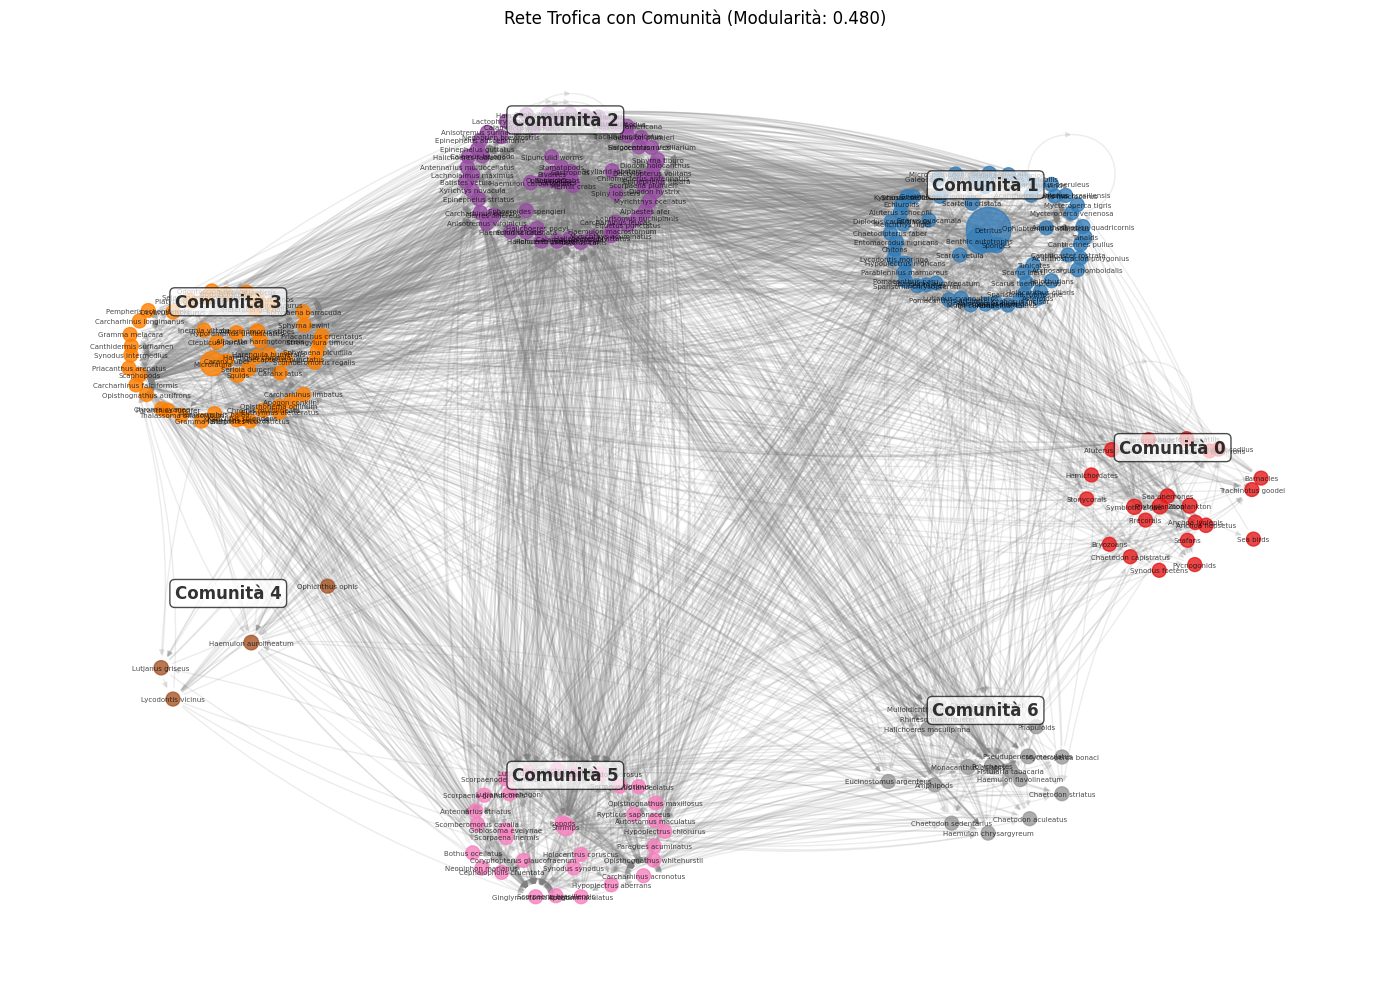

In [47]:
# Visualizzazione del grafo colorato per comunità
# Creiamo un layout che raggruppa i nodi per comunità

def community_layout(G, partition, scale=3, seed=42):
    """
    Crea un layout che posiziona i nodi della stessa comunità vicini tra loro.
    """
    np.random.seed(seed)

    # Raggruppa i nodi per comunità
    communities = {}
    for node, comm in partition.items():
        if comm not in communities:
            communities[comm] = []
        communities[comm].append(node)

    # Posiziona i centroidi delle comunità in cerchio
    n_comm = len(communities)
    comm_centers = {}
    for i, comm in enumerate(sorted(communities.keys())):
        angle = 2 * np.pi * i / n_comm
        comm_centers[comm] = (scale * np.cos(angle), scale * np.sin(angle))

    # Per ogni comunità, posiziona i nodi attorno al centroide
    pos = {}
    for comm, nodes in communities.items():
        cx, cy = comm_centers[comm]
        # Creiamo un sottografo per la comunità
        subgraph = G.subgraph(nodes)
        # Layout locale per i nodi della comunità
        if len(nodes) > 1:
            local_pos = nx.spring_layout(subgraph, k=0.5, seed=seed, iterations=50)
        else:
            local_pos = {nodes[0]: (0, 0)}

        # Trasliamo le posizioni locali al centroide della comunità
        for node, (x, y) in local_pos.items():
            pos[node] = (cx + x * 0.8, cy + y * 0.8)

    return pos

plt.figure(figsize=(14, 10))

# Layout che raggruppa i nodi per comunità
pos = community_layout(G, partition, scale=4, seed=42)

# Colori per comunità
colors = [partition[n] for n in G.nodes()]

# Dimensione nodi proporzionale all'impatto
node_sizes = [energetic_results.get(n, 0) * 5 + 100 for n in G.nodes()]

nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=node_sizes,
                        cmap=plt.cm.Set1, alpha=0.8)
nx.draw_networkx_edges(G, pos, alpha=0.15, arrows=True, arrowsize=8,
                        edge_color='gray', connectionstyle="arc3,rad=0.1")
nx.draw_networkx_labels(G, pos, font_size=5, alpha=0.7)

# Aggiungiamo etichette per le comunità
comm_centers = {}
for node, comm in partition.items():
    if comm not in comm_centers:
        comm_centers[comm] = []
    comm_centers[comm].append(pos[node])

for comm, positions in comm_centers.items():
    cx = np.mean([p[0] for p in positions])
    cy = np.mean([p[1] for p in positions])
    plt.annotate(f'Comunità {comm}', (cx, cy + 0.6), fontsize=12,
                 fontweight='bold', ha='center', alpha=0.8,
                 bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

plt.title(f"Rete Trofica con Comunità (Modularità: {modularity:.3f})")
plt.axis('off')
plt.tight_layout()
plt.show()

In [48]:
# Analisi: come le estinzioni si propagano tra comunità
def analyze_extinction_by_community(graph, partition, primary_node, th=0.5):
    """
    Analizza quali comunità vengono colpite dall'estinzione di un nodo.
    Ritorna un dizionario con il conteggio delle estinzioni per comunità.
    """
    temp_graph = graph.copy()
    initial_energy = dict(graph.in_degree(weight='weight'))

    temp_graph.remove_node(primary_node)
    extinct_nodes = {primary_node}

    new_extinctions = True
    while new_extinctions:
        new_extinctions = False
        to_remove = []
        for n in temp_graph.nodes():
            if initial_energy[n] > 0:
                current_energy = temp_graph.in_degree(n, weight='weight')
                if current_energy <= th * initial_energy[n]:
                    to_remove.append(n)
                    new_extinctions = True
        for n in to_remove:
            if n not in extinct_nodes:
                extinct_nodes.add(n)
                temp_graph.remove_node(n)

    # Conta estinzioni per comunità
    extinction_by_comm = {}
    for node in extinct_nodes:
        if node != primary_node:  # Escludiamo l'estinzione primaria
            comm = partition[node]
            extinction_by_comm[comm] = extinction_by_comm.get(comm, 0) + 1

    return extinction_by_comm, extinct_nodes

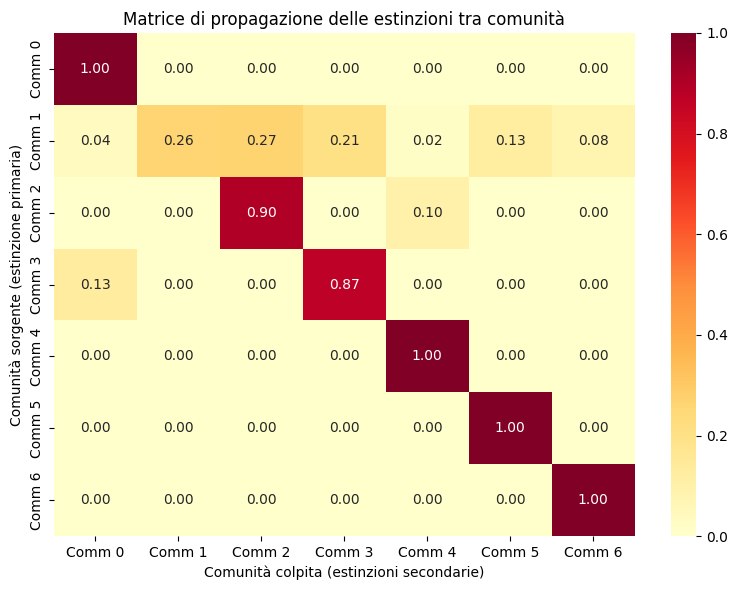

In [55]:
# Visualizzazione: Heatmap delle estinzioni tra comunità
n_communities = len(set(partition.values()))
extinction_matrix = np.zeros((n_communities, n_communities))

# Per ogni specie, calcoliamo quante estinzioni causa in ogni comunità
for node in G.nodes():
    if G.out_degree(node) > 0:  # Escludiamo apex predators
        source_comm = partition[node]
        comm_ext, _ = analyze_extinction_by_community(G, partition, node, th=0.5)
        for target_comm, count in comm_ext.items():
            extinction_matrix[source_comm][target_comm] += count

# Normalizzo le righe
extinction_matrix = extinction_matrix / extinction_matrix.sum(axis=1, keepdims=True)

plt.figure(figsize=(8, 6))
sns.heatmap(extinction_matrix, annot=True, fmt='.2f', cmap='YlOrRd',
            xticklabels=[f'Comm {i}' for i in range(n_communities)],
            yticklabels=[f'Comm {i}' for i in range(n_communities)])
plt.xlabel('Comunità colpita (estinzioni secondarie)')
plt.ylabel('Comunità sorgente (estinzione primaria)')
plt.title('Matrice di propagazione delle estinzioni tra comunità')
plt.tight_layout()
plt.show()

In [54]:
# Confronto diagonale vs off-diagonale
diag = np.diag(extinction_matrix).mean()  # Media estinzioni intra-community
off_diag = extinction_matrix[~np.eye(n_communities, dtype=bool)].mean()  # Media inter-community
print(f"\nMedia estinzioni INTRA-community (diagonale): {diag:.2f}")
print(f"Media estinzioni INTER-community (off-diagonale): {off_diag:.2f}")


Media estinzioni INTRA-community (diagonale): 0.86
Media estinzioni INTER-community (off-diagonale): 0.02


Complessivamente possiamo dunque dire che il più delle volte un'estinzione primaria influenza la propria comunità, cioè l'insieme delle specie che più sono connesse tra di loro.

# 2. Analisi esplorativa delle reti
Analizziamo le reti trofiche e cerchiamo pattern nascosti. L'obiettivo è identificare pattern che permettono di classificare le diverse reti del dataset messo a disposizione dal professore rispetto a fragilità alle estinzioni primarie e struttura.

In [18]:
# Raccogliamo tutti i file CSV
file_list = sorted(glob.glob("FW_*.csv"))

Di seguito andiamo ad estrarre una serie di feature per la creazione di una rappresentazione compatta delle reti
- **Cardinalità delle specie** ($S$): Indica la cardinalità dei nodi (specie) appartenenti alla rete.
- **Modularità**: Parametro che quantifica la struttura a comunità, indicando quanto i nodi siano densamente connessi tra loro rispetto a una distribuzione casuale.
- **Connettività**: Misura della densità dei legami all'interno del grafo, definita come il rapporto tra archi esistenti e archi possibili.
- **AVG_energy**: Valore medio del flusso energetico in ingresso nel sistema.
- $AUC_{robustness}$: Indica quanto l'estinzione di ogni nodo influenza la rete per ogni soglia. Un valore basso indica una rete resistente alle estinzioni.

In [19]:
# Per ognuno dei file andiamo ad estrarre le feature di interesse

network_data = []

for file in file_list:
    try:
        # Caricamento e preparazione del grafo
        df = pd.read_csv(file, index_col=0)
        all_species = sorted(list(set(df.index) | set(df.columns)))
        df_square = df.reindex(index=all_species, columns=all_species, fill_value=0)
        G = nx.from_pandas_adjacency(df_square, create_using=nx.DiGraph)

        # --- ESTRAZIONE FEATURE ---
        S = len(G.nodes())           # Numero specie
        L = len(G.edges())           # Numero link
        LS = L / S if S > 0 else 0  # Linkage Density
        C = L / (S**2) if S > 0 else 0 # Connettività

        # Forza energetica media (In-degree pesato medio)
        avg_energy = np.mean([d for n, d in G.in_degree(weight='weight')])

        # Modularità (usando Louvain su grafo non orientato)
        partition = community_louvain.best_partition(G.to_undirected())
        modularity = community_louvain.modularity(partition, G.to_undirected())

        # ROBUSTEZZA al variare della soglia TH
        avg_r = []
        for i in np.arange(0,1,0.1):
          impacts = [simulate_energetic_extinction(G, n, th=i) for n in G.nodes()]
          avg_r.append(np.mean(impacts) / S) # Normalizzato per la dimensione della rete

        auc_robustness = np.trapezoid(avg_r) # Calcola l'area sotto la curva

        # Salvataggio dati
        network_data.append({
            'filename': file,
            'size': LS,
            'connectance': C,
            'modularity': modularity,
            'avg_energy_flow': avg_energy,
            'auc_robustness': auc_robustness
        })
        print(f"Finito {file}: Connettività={C}, AUC={auc_robustness:.3f}")

    except Exception as e:
        print(f"Errore nel file {file}: {e}")

Finito FW_001.csv: Connettività=0.115625, AUC=0.353
Finito FW_002.csv: Connettività=0.19387755102040816, AUC=0.630
Finito FW_003.csv: Connettività=0.16198979591836735, AUC=0.571
Finito FW_004.csv: Connettività=0.13671875, AUC=0.386
Finito FW_005.csv: Connettività=0.21332644628099173, AUC=0.337
Finito FW_006.csv: Connettività=0.2544444444444444, AUC=0.374
Finito FW_007.csv: Connettività=0.0959201388888889, AUC=0.245
Finito FW_008.csv: Connettività=0.053434622022225445, AUC=0.066
Finito FW_009.csv: Connettività=0.150625, AUC=0.298
Finito FW_010.csv: Connettività=0.16305062458908612, AUC=0.300
Finito FW_011.csv: Connettività=0.03111111111111111, AUC=0.046
Finito FW_012_01.csv: Connettività=0.03745541022592152, AUC=0.078
Finito FW_012_02.csv: Connettività=0.029359254116246777, AUC=0.053
Finito FW_013_01.csv: Connettività=0.04292929292929293, AUC=0.066
Finito FW_013_02.csv: Connettività=0.040479001517962555, AUC=0.050
Finito FW_013_03.csv: Connettività=0.039612097304405, AUC=0.072
Finito FW

In [20]:
# Dunque creiamo la rappresentazione compatta di feature dei grafi
df_master = pd.DataFrame(network_data)
df_master

,filename,size,connectance,modularity,avg_energy_flow,auc_robustness
0,FW_001.csv,4.625000,0.115625,0.295633,0.900000,0.352500
1,FW_002.csv,2.714286,0.193878,0.431341,0.642900,0.630102
2,FW_003.csv,4.535714,0.161990,0.278139,0.928571,0.570791
3,FW_004.csv,4.375000,0.136719,0.324082,0.875000,0.385742
4,FW_005.csv,9.386364,0.213326,0.362115,0.909187,0.337293
5,FW_006.csv,7.633333,0.254444,0.255402,0.899967,0.373889
6,FW_007.csv,4.604167,0.095920,0.508873,77.739583,0.245009
7,FW_008.csv,13.305221,0.053435,0.486007,0.959702,0.066023
8,FW_009.csv,6.025000,0.150625,0.354682,0.924675,0.297813
9,FW_010.csv,6.358974,0.163051,0.369244,0.897579,0.300131


Una volta ottenuta la rappresentazione, andiamo ad visualizzare la correlazione e applichiamo tecniche non supervisionate ai dati.

In [21]:
# Escludiamo il 'filename' che è una stringa
features_cols = ['size', 'connectance', 'modularity', 'avg_energy_flow', 'auc_robustness']
X = df_master[features_cols]

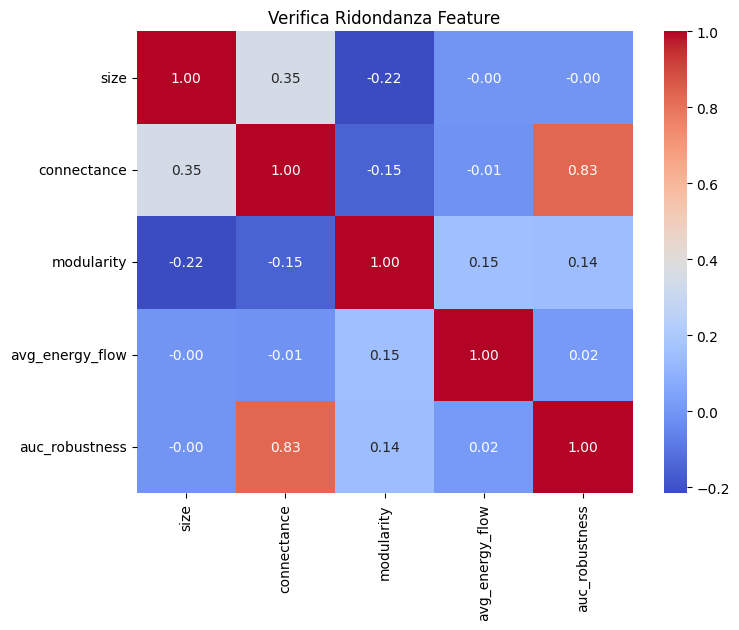

In [22]:
# Calcoliamo la matrice di correlazione
corr_matrix = df_master[['size', 'connectance', 'modularity', 'avg_energy_flow', 'auc_robustness']].corr()

# Visualizziamo con una heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Verifica Ridondanza Feature")
plt.show()

Nonostante alcune correlazioni elevate (es. size-avg_energy_flow ~$0.87$), decidiamo di mantenere tutte le feature poiché UMAP, essendo un algoritmo non lineare, gestisce bene la ridondanza catturando strutture complesse nei dati. Una valutazione a posteriori ha confermato che l'inclusione di tali feature contribuisce a una separazione dei cluster più definita e a una rappresentazione più fedele delle dinamiche della rete.

## 2.1 UMAP e Clusterizzazione
Una volta definito il set di feature, abbiamo proceduto con un'analisi esplorativa dei dati (**EDA**) applicata alle reti. L'obiettivo principale di questa fase è l'identificazione e la successiva caratterizzazione di cluster omogenei, al fine di isolare pattern strutturali ricorrenti e analizzare le proprietà che guidano la formazione dei gruppi all'interno del dataset.

In [23]:
# Standardizzazione e riduzione della dimensionalità con UMAP
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Inizializzazione UMAP
# n_neighbors: bilancia tra struttura locale e globale
# min_dist: controlla quanto i punti sono vicini
reducer = umap.UMAP(n_neighbors=10,
                    min_dist=0.4,
                    metric='cosine',
                    n_components=2,
                    random_state=42)

X_embedded = reducer.fit_transform(X_scaled)

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [24]:
# Applichiamo K-Means scegliendo il K con il silhouette score
best_k = None
best_score = -1
for i in range(2,10):

  kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
  score = silhouette_score(X_embedded, kmeans.fit_predict(X_embedded))

  if score > best_score:
    best_k = i
    best_score = score

  print(f"Silhouette Score per {i} cluster: {score}")

print(f"Il miglior numero di cluster è {best_k} con Silhouette Score di {best_score}")

# Scelgo la miglior suddivisione
kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=10)
df_master['cluster'] = kmeans_final.fit_predict(X_embedded)

Silhouette Score per 2 cluster: 0.5460426807403564
Silhouette Score per 3 cluster: 0.7275955080986023
Silhouette Score per 4 cluster: 0.7067970633506775
Silhouette Score per 5 cluster: 0.6032253503799438
Silhouette Score per 6 cluster: 0.487007200717926
Silhouette Score per 7 cluster: 0.39360934495925903
Silhouette Score per 8 cluster: 0.38897329568862915
Silhouette Score per 9 cluster: 0.3747801184654236
Il miglior numero di cluster è 3 con Silhouette Score di 0.7275955080986023


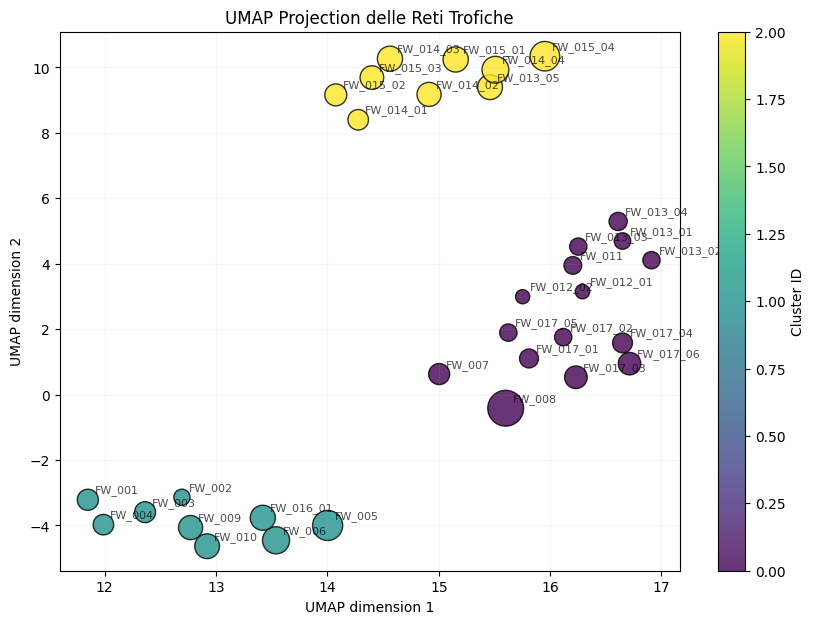

In [25]:
# Visualizzazione UMAP
plt.figure(figsize=(10, 7))

# Scatter plot usando le coordinate UMAP
scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1],
            c=df_master['cluster'],
            s=df_master['size']*50,
            cmap='viridis', alpha=0.8, edgecolors='k')

# Etichettiamo i punti
for i, txt in enumerate(df_master['filename']):
    plt.annotate(txt.split('.')[0], (X_embedded[i, 0], X_embedded[i, 1]),
                 fontsize=8, alpha=0.7, xytext=(5,5), textcoords='offset points')

plt.title("UMAP Projection delle Reti Trofiche")
plt.xlabel("UMAP dimension 1")
plt.ylabel("UMAP dimension 2")
plt.colorbar(scatter, label='Cluster ID')
plt.grid(True, alpha=0.1)
plt.show()

Nel risultato ottenuto è possibile osservare la formazione di cluster ben separati nello spazio UMAP. Per validare il significato ecologico di questa clusterizzazione, ho verificato l'ipotesi che i cluster potessero corrispondere ai **biomi di appartenenza** (mare, fiume, lago).

A tale scopo, ho etichettato manualmente ciascuna rete in base all'ambiente di provenienza, confrontando poi questa classificazione "reale" con quella ottenuta dall'algoritmo.

In [26]:
bioma_mapping = {
    # --- FIUMI (Streams and Rivers) ---
    "FW_001": "Fiume",      # Parana River (Brasile)
    "FW_002": "Fiume",      # Cerrado River (Brasile)
    "FW_011": "Fiume",      # Stream in Maine (USA)
    "FW_012_01": "Fiume",   # Stream in North Carolina (USA)
    "FW_012_02": "Fiume",   # Stream in North Carolina (USA)
    "FW_013_01": "Fiume",   # Streams in Otago (New Zealand)
    "FW_013_02": "Fiume",
    "FW_013_03": "Fiume",
    "FW_013_04": "Fiume",
    "FW_013_05": "Fiume",
    "FW_014_01": "Fiume",   # Streams in Otago (New Zealand)
    "FW_014_02": "Fiume",
    "FW_014_03": "Fiume",
    "FW_014_04": "Fiume",
    "FW_015_01": "Fiume",   # Streams in Otago (New Zealand)
    "FW_015_02": "Fiume",
    "FW_015_03": "Fiume",
    "FW_015_04": "Fiume",

    # --- MARE / OCEANO (Marine, Fisheries and Reefs) ---
    "FW_003": "Mare",       # Angola Fishery (Oceano Atlantico)
    "FW_005": "Mare",       # Gulf of Cadiz (Spagna)
    "FW_006": "Mare",       # Gulf of Mexico (Laguna Alvarado)
    "FW_007": "Mare",       # St Marks (Seagrass - Florida)
    "FW_008": "Mare",       # Caribbean Marine Food Web
    "FW_016_01": "Mare",    # Mondego Estuary (Portogallo)
    "FW_017_01": "Mare",    # Coral Reef (U.S. Virgin Islands)
    "FW_017_02": "Mare",    # Coral Reef (Marshall Islands)
    "FW_017_03": "Mare",    # Coral Reef (Madagascar)
    "FW_017_04": "Mare",    # Coral Reef (Hawaii)
    "FW_017_05": "Mare",    # Coral Reef (New Caledonia)
    "FW_017_06": "Mare",    # Coral Reef (Okinawa, Japan)

    # --- LAGHI (Lakes and Reservoirs) ---
    "FW_004": "Lago",       # Itaipu Reservoir (Bacino/Lago artificiale)
    "FW_009": "Lago",       # Oxbow Lakes (Pantanal, Brasile)
    "FW_010": "Lago",       # Oxbow Lakes (Pantanal, Brasile)
}

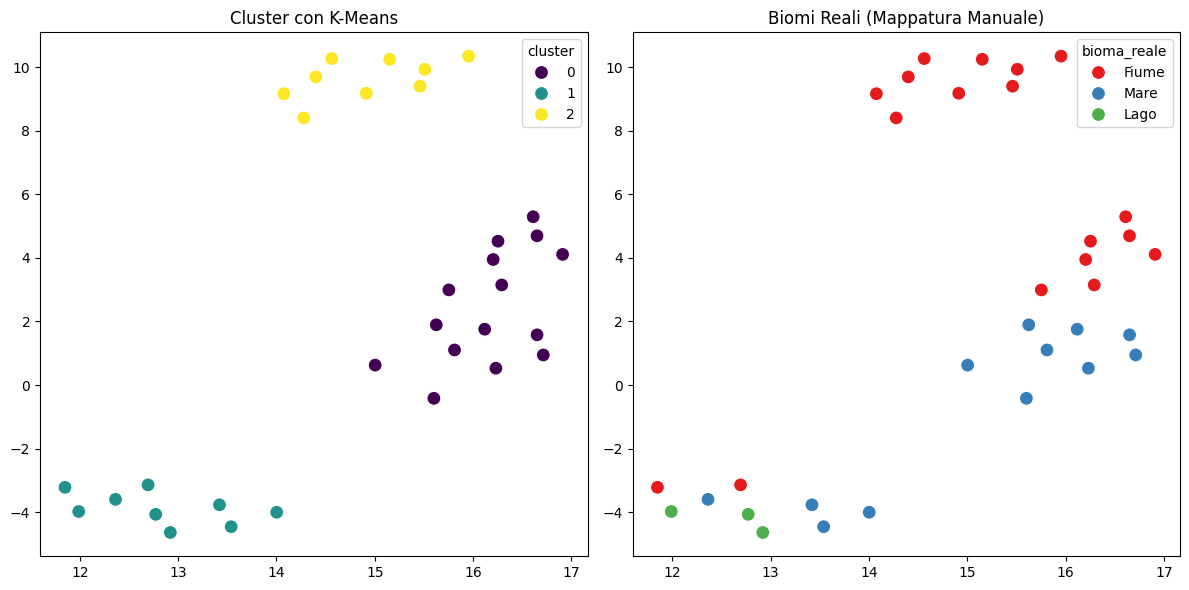

In [27]:
# 1. Applichiamo la mappatura
df_master['bioma_reale'] = df_master['filename'].str.replace('.csv', '', regex=False).map(bioma_mapping)

# 2. Plot UMAP colorato per BIOMA REALE
plt.figure(figsize=(12, 6))

# Grafico a sinistra: Cluster decisi dal K-Means
plt.subplot(1, 2, 1)
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=df_master['cluster'], palette='viridis', s=100)
plt.title("Cluster con K-Means")

# Grafico a destra: Biomi reali
plt.subplot(1, 2, 2)
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=df_master['bioma_reale'], palette='Set1', s=100)
plt.title("Biomi Reali (Mappatura Manuale)")

plt.tight_layout()
plt.show()

L'analisi indica che le proprietà emergenti della rete — quali la modularità, la lunghezza delle catene trofiche e la robustezza energetica descritta da Bellingeri et al. — agiscono come driver strutturali più potenti della semplice appartenenza tassonomica o ambientale. In questo contesto, i tre cluster identificati possono essere interpretati come 'archetipi di organizzazione bioenergetica': modelli universali di flusso di materia ed energia che la natura adotta per garantire la stabilità del sistema. Ad esempio, la presenza di reti fluviali e marine nello stesso cluster evidenzia come sistemi con livelli simili di connettività e sensibilità alle soglie energetiche ($th$) possano condividere la stessa architettura di resilienza, indipendentemente dalla salinità o dalla profondità dell'habitat. In conclusione, il machine learning non supervisionato ha permesso di spostare il focus dalla 'geografia' alla 'funzione', dimostrando che l'identità di una rete ecologica risiede nella sua dinamica strutturale e nella sua risposta agli stress energetici."

Scartata l'ipotesi precedente, andiamo a verificare il significato dei cluster ottenuti, verificandone il legame rispetto alla **fragilità**.

In [28]:
summary = (
    df_master
    .groupby('cluster')[['modularity','auc_robustness','connectance', 'size', 'avg_energy_flow']]
    .mean()
    .sort_values('auc_robustness')  # basso = robusto
)

summary

,modularity,auc_robustness,connectance,size,avg_energy_flow
cluster,,,,,
2,0.195582,0.015900,0.064753,6.354528,6.354528
0,0.405100,0.062344,0.038064,4.168556,6.916871
1,0.326579,0.382953,0.174048,5.799357,0.868413


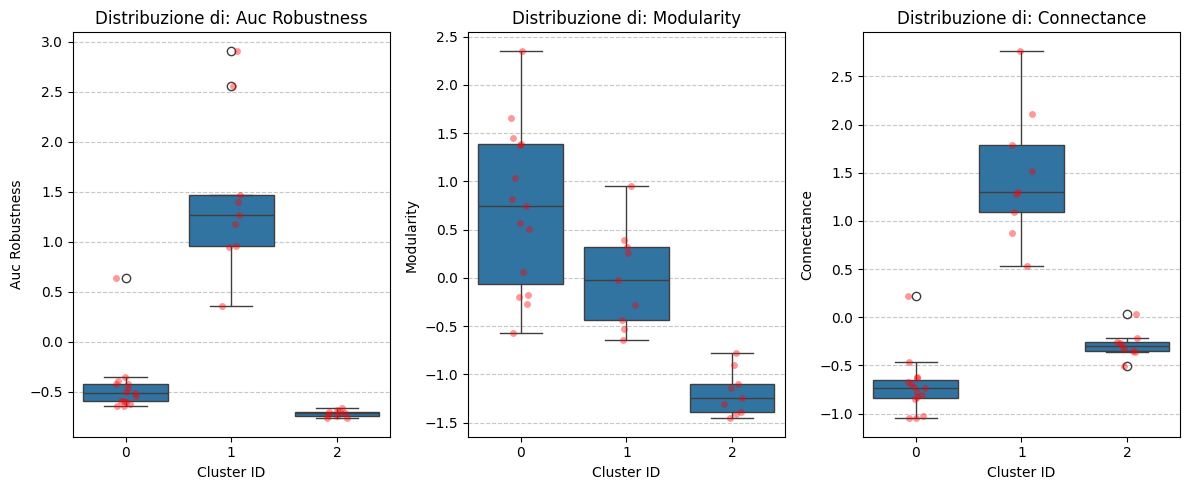

In [29]:
# Analizziamo la differenza dei cluster per fragilità
X_scaled = pd.DataFrame(X_scaled, columns=features_cols)
X_scaled['cluster'] = df_master['cluster']

# Visualizziamo con boxplot
metrics_to_plot = ['auc_robustness', 'modularity', 'connectance']
plt.figure(figsize=(12, 5))

for i, metric in enumerate(metrics_to_plot):
    plt.subplot(1, 3, i+1)
    sns.boxplot(x='cluster', y=metric, data=X_scaled, legend=False)
    sns.stripplot(x='cluster', y=metric, data=X_scaled, color='red', alpha=0.4)

    # Formattazione estetica
    title_label = metric.replace('_', ' ').title()
    plt.title(f"Distribuzione di: {title_label}")
    plt.xlabel("Cluster ID")
    plt.ylabel(title_label)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

Notiamo che i cluster sono suddivisi in base alla loro fragilità, che è strettamente legata alla connettività e alla presenza di comunità interne. Notiamo che:
- Un'alta connettività della rete causa una maggiore fragilità rispetto alle estinzioni
- Una bassa modularità ma con bassa connettività permette alla rete di essere resistente rispetto alle estinzioni primarie.
- Un'alta modularità indica comunità più forti, quindi le estinzioni primarie avranno effetto soprattuto nella comunità di appartenenza.

Sebbene la fragilità contribuisca al processo di clustering, i risultati indicano che reti con simili livelli di modularità e connettività tendono a condividere anche livelli simili di fragilità, evidenziando un pattern strutturale coerente tra organizzazione topologica e robustezza della rete